In [212]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

1. Download ETFs' most recent data
2. Use market cap to filter out the largest ETFs by market cap
3. Use correlation to filter out the most uncorrelated ETFs
4. Generate selected 40 tickers as pool
5. Calculate the positions' weights

# Parameters and Settings

In [440]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
    '159916',
    '159918',
    '159932',
    '159933',
    '159938',
    '159951',
    '510090',
    '510110',
    '510270',
    '510580',
    '511030',
    '512010',
    '512290',
    '512560'
]
len(cur_positions)

14

# General Import of ETF Data

In [213]:
def handle_data_files_return_tickers(file_path):
    ch_etfs_df = pd.read_csv(file_path, engine="python")
    ch_etfs_df.dropna(inplace = True)
    ch_etfs_df['基金规模\n[单位] 元'] = ch_etfs_df['基金规模\n[单位] 元'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'] = ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df.sort_values("基金规模\n[单位] 元", ascending=False, inplace =True)
    ch_etfs_df = ch_etfs_df
    ch_etfs = ch_etfs_df.copy()
    ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
    ch_etfs_ticker = list(ch_etfs['code'].unique())
    return ch_etfs_ticker

def select_df_from_db_by_tickers(path, ticker_list):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    
    tickers_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Reading: ", ticker)
            df = pd.read_csv(path+ticker+".csv")
            tickers_data.append(df)
        tickers_data_concated = pd.concat(tickers_data)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']
    else:
        df = pd.read_csv(path+ticker_list[0]+".csv")
        tickers_data_concated = df
    return tickers_data_concated

def get_df_date_price_code(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'close']].dropna()
#             ticker_df.columns = [date_col,ticker]
#             ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
#             tickers_data_concated.reset_index(inplace=True)
#             del tickers_data_concated['index']
        except:
            pass
    tickers_data_concated = pd.concat(ticker_df_list)
    return tickers_data_concated

# 先为之后使用reduce铺路：创造一个merge的函数，这里的目的是为了将多资产数据基于date_col进行merge：
def merge_df(df1, df2, date_col="date"):
    # By default the etf's date_col goes by 'date'
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

In [214]:
etf_ticker_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_ETFs.csv"
etf_path_to_csv = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
ch_etfs_tickers = handle_data_files_return_tickers(etf_ticker_path)
tickers_data_concated = select_df_from_db_by_tickers(etf_path_to_csv, ch_etfs_tickers)

Reading:  510500
Reading:  510050
Reading:  510300
Reading:  510330
Reading:  159919
Reading:  510180
Reading:  159915
Reading:  512960
Reading:  512950
Reading:  510810
Reading:  512880
Reading:  510900
Reading:  518880
Reading:  510310
Reading:  159901
Reading:  512500
Reading:  159920
Reading:  159949
Reading:  510230
Reading:  510850
Reading:  159959
Reading:  511030
Reading:  510390
Reading:  510510
Reading:  510380
Reading:  512000
Reading:  159962
Reading:  510360
Reading:  159928
Reading:  159922
Reading:  510880
Reading:  159938
Reading:  510590
Reading:  159902
Reading:  512660
Reading:  512070
Reading:  159939
Reading:  511220
Reading:  512900
Reading:  512380
Reading:  512800
Reading:  512580
Reading:  159905
Reading:  159952
Reading:  159910
Reading:  511270
Reading:  513050
Reading:  159948
Reading:  512980
Reading:  511020
Reading:  513500
Reading:  510580
Reading:  513660
Reading:  512330
Reading:  512010
Reading:  159916
Reading:  512160
Reading:  510560
Reading:  5125

In [215]:
tickers_data_concated.head()

,date,open,close,high,low,volume,code
0,2013-03-15,0.967,0.970,0.985,0.955,3259273.0,510500
1,2013-03-18,0.955,0.954,0.972,0.953,936962.0,510500
2,2013-03-19,0.956,0.960,0.960,0.941,1080499.0,510500
3,2013-03-20,0.960,0.985,0.986,0.958,501195.0,510500
4,2013-03-21,0.985,0.995,0.996,0.981,698243.0,510500


# Use Volume to Rank

Every year we will need to check using this function. The most recent time of update is 20200221

In [216]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

def rank_by_vol_ewm(df, date_col, window_span, rank_num, ascending_default = False):
    vol_col_rename = "{}_vol_ewm".format(window_span)
    df['vol_ewm_rank'] = df.groupby([date_col])[vol_col_rename].apply(lambda x: x.rank(ascending = ascending_default))
    vol_rank_condition = df['vol_ewm_rank']<=rank_num
    vol_filtered_df = df[(df[date_col]==df[date_col].values[-1])&(vol_rank_condition)]
    vol_filtered_df.sort_values("vol_ewm_rank", ascending=True, inplace=True)
    return vol_filtered_df

def filtered_tickers(df, code_col):
    filtered_tickers = list(df[code_col].unique().astype(str))
    return filtered_tickers

In [217]:
vol_added_df = add_vol_ewm_col(tickers_data_concated,'code','volume',252)
vol_filtered_df = rank_by_vol_ewm(vol_added_df, 'date', 252, 50, ascending_default = False)
vol_filtered_tickers = filtered_tickers(vol_filtered_df, 'code')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [218]:
len(vol_filtered_tickers)

50

# Calculate Correlations as Filters

In [219]:
def merge_df_for_corr(ticker_df_list, date_col):
    # Here below merge_df is a function instead of a variable
    
    merged_all = reduce(merge_df, ticker_df_list)
    # For etf data the date col is 'date'
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    return merged_all

def get_df_date_price_code_returns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

def get_df_date_price_code_cumreturns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

In [220]:
df_returns = get_df_date_price_code_returns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
df_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
merged_returns = merge_df_for_corr(df_returns, "date")
merged_cumreturns = merge_df_for_corr(df_cum_returns, "date")

Reading Assets:  512880
Reading Assets:  510900
Reading Assets:  159949
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159920
Reading Assets:  512000
Reading Assets:  510300
Reading Assets:  518880
Reading Assets:  510500
Reading Assets:  512660
Reading Assets:  510330
Reading Assets:  512800
Reading Assets:  159919
Reading Assets:  512500
Reading Assets:  512380
Reading Assets:  510850
Reading Assets:  512960
Reading Assets:  512290
Reading Assets:  512280
Reading Assets:  159939
Reading Assets:  510310
Reading Assets:  512090
Reading Assets:  513500
Reading Assets:  159952
Reading Assets:  513050
Reading Assets:  512010
Reading Assets:  512160
Reading Assets:  512980
Reading Assets:  512400
Reading Assets:  159901
Reading Assets:  510510
Reading Assets:  512690
Reading Assets:  512180
Reading Assets:  513100
Reading Assets:  512950
Reading Assets:  512900
Reading Assets:  512100
Reading Assets:  510180
Reading Assets:  159922
Reading Assets:  159905
Reading Assets: 

## Plot assets and correlation matrixs

In [221]:
# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

In [222]:
# fig = plt.figure(figsize = (35, 25))
# ax = fig.add_subplot(111)
# ax = sns.heatmap(merged_returns.corr(),\
#                 annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
# plt.title("Correlation Heatmap on 50 ETFs' Returns", fontsize = 20);

# Filter the top 40 ETFs by Lowest Correlations

In [223]:
def select_N_lowest_corr_assets(merged_all, asset_category, n):
    # asset_category be default for etf is 'etf'
    # Create ETFs' correlation matrix dataframe
    merged_all_corr = merged_all.corr()
    merged_all_corr_abs = abs(merged_all_corr)
    corr_mean_dict = {}
    for row in merged_all_corr_abs.iterrows():
        row_list = list(row)
        print(row_list[0])
        print(np.mean(row_list[1]))
        corr_mean_dict[row_list[0]] = np.mean(row_list[1])
        print("========")
    corr_mean_df = pd.DataFrame()
    corr_mean_df[asset_category] = corr_mean_dict.keys()
    corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
    corr_mean_df_assets = corr_mean_df.sort_values("abs_corr_mean", ascending=True)
    lowest_corr_assets_list = list(corr_mean_df_assets[asset_category])[:n]
    return lowest_corr_assets_list, corr_mean_df_assets

def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
    return df

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Calculating Signal for: ", ticker)
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==float(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
        signal_data_df = pd.concat(signal_data)
    else:
        print("Calculating Signal for: ", ticker_list[0])
        try:                
            print("getting thru")
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
#             last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
#             signal_data.append(signal_df)
#             signal_record.append(last_signal)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df
    
def make_numeric_signals(series):
    for item in series:
#         print(item)
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0
        
def generate_most_recent_signal_data_v1(signal_data_df, date_col, code_col):
    # v1 is the version of generating the og macd signals
    signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
    signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([code_col])['SIGNAL_DIRECTION'].diff()
    signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
    most_recent_signals = signal_data_df.groupby([code_col])[[date_col,code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
    return most_recent_signals

def check_macd_signal_plot(signal_data_df, ticker, cols_list_to_plot, code_col, N_tails, date_col):
    signal_data_df_copy = signal_data_df.copy()
    signal_data_df_copy.set_index(date_col, inplace = True)
    df_to_plot = signal_data_df_copy[signal_data_df_copy[code_col]==ticker][cols_list_to_plot].tail(N_tails)
    df_to_plot.plot(figsize = (18, 6))
    plt.title("{}".format(ticker))
    
lowest_corr_etf_list,corr_mean_df_assets = select_N_lowest_corr_assets(merged_returns, "etf", 40)
# Calculate MACD
# P.S. MACD is calculated based on the following df structure: date, open, high, low, close
lowest_corr_etf_df = select_df_from_db_by_tickers(etf_path_to_csv, lowest_corr_etf_list)
lowest_corr_etf_macd_signals = calc_macd_signals(lowest_corr_etf_df, lowest_corr_etf_list, 'code', 'float','close')
most_recent_etf_macd_signals = generate_most_recent_signal_data_v1(lowest_corr_etf_macd_signals, 'date','code')

512880
0.6879901720037322
510900
0.5429980786334684
159949
0.7262495837032481
510050
0.6594694470906617
159915
0.6693979606697894
159920
0.49913076505528925
512000
0.6847017902852955
510300
0.734108833285128
518880
0.13540867258528422
510500
0.5248871437241892
512660
0.6239894913908037
510330
0.7338582415194403
512800
0.6296508904685872
159919
0.6475379194623345
512500
0.7696227628846211
512380
0.8350785095291323
510850
0.7843943409846935
512960
0.8133850796312672
512290
0.5805487073478479
512280
0.8343106817120426
159939
0.6586368040159187
510310
0.7424620416093434
512090
0.8364077608505938
513500
0.2794044749584615
159952
0.7460481690504149
513050
0.5334643064924913
512010
0.5931586917355453
512160
0.830377821339103
512980
0.7369997208565258
512400
0.638563118655719
159901
0.5490345953503549
510510
0.7298825194947989
512690
0.6419992345553657
512180
0.8299395138226997
513100
0.3229186435976913
512950
0.8146102564773563
512900
0.6899249041329897
512100
0.7297777759357861
510180
0.5401

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Calculating Signal for:  512100
Calculating Signal for:  510510
Calculating Signal for:  510330
Calculating Signal for:  510300
Calculating Signal for:  512980
Calculating Signal for:  510310
Calculating Signal for:  159952
Calculating Signal for:  512500
Calculating Signal for:  512990


In [224]:
# This could be different from our current position holdings
most_recent_etf_macd_signals['TYPE'] = 'TARGET'
most_recent_etf_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
1602,2020-02-26,518880,多头状态,NO CHANGE,TARGET
3091,2020-02-26,513500,空头状态,NO CHANGE,TARGET
4744,2020-02-26,513100,空头状态,NO CHANGE,TARGET
6531,2020-02-26,159920,空头状态,NO CHANGE,TARGET
8220,2020-02-26,510500,多头状态,NO CHANGE,TARGET
8974,2020-02-26,513050,空头状态,NO CHANGE,TARGET
11437,2020-02-26,510180,多头状态,NO CHANGE,TARGET
13223,2020-02-26,510900,空头状态,NO CHANGE,TARGET
15686,2020-02-26,159901,多头状态,NO CHANGE,TARGET
15875,2020-02-26,512290,空头状态,SHORT,TARGET


In [226]:
cur_pos_prices = select_df_from_db_by_tickers(etf_path_to_csv, cur_positions)
cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, 'code', 'float','close')
most_recent_cur_pos_etf_macd_signals = generate_most_recent_signal_data_v1(cur_pos_etf_macd_signals, 'date','code')
most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'
signal_df = most_recent_cur_pos_etf_macd_signals.merge(most_recent_etf_macd_signals, on = ['date','code'], how = 'outer')

Reading:  159916
Reading:  159918
Reading:  159932
Reading:  159933
Reading:  159938
Reading:  159951
Reading:  510090
Reading:  510110
Reading:  510270
Reading:  510580
Reading:  511030
Reading:  512010
Reading:  512290
Reading:  512560
Calculating Signal for:  159916
Calculating Signal for:  159918
Calculating Signal for:  159932
Calculating Signal for:  159933
Calculating Signal for:  159938
Calculating Signal for:  159951
Calculating Signal for:  510090
Calculating Signal for:  510110
Calculating Signal for:  510270
Calculating Signal for:  510580
Calculating Signal for:  511030
Calculating Signal for:  512010
Calculating Signal for:  512290
Calculating Signal for:  512560


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Risk Parity

In [227]:
from scipy.optimize import minimize

def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

In [228]:
wts, risk = get_smart_weight(merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)
df_wts = pd.DataFrame(wts)
df_wts.reset_index(inplace = True)
df_wts.columns = ['ETF', 'Portfolio_Weight']

In [229]:
# Top 40 ETF ranked by 252-day-vol_ewm on 20200221
# list(merged_returns.columns)

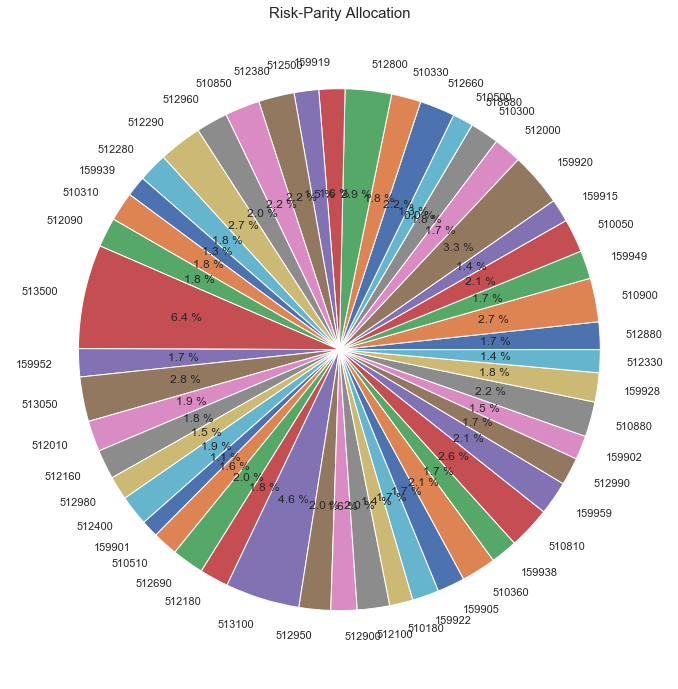

In [230]:
etfs = list(df_wts['ETF'])
weights = list(df_wts['Portfolio_Weight'])
# 保证圆形
plt.figure(1, figsize = (12, 12))
plt.axes(aspect=1)
plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
plt.title("Risk-Parity Allocation", fontsize = 15)
plt.show()

In [231]:
signal_df['code'] = signal_df['code'].astype(str)
signal_df['WEIGHT'] = ""

In [232]:
# match the weights of each ETF
for i, code_wts in enumerate(df_wts['ETF']):
    for j, code_signal in enumerate(signal_df['code']):
        if code_wts == code_signal:
            signal_df['WEIGHT'].values[j]=df_wts['Portfolio_Weight'].values[i]
            
# create the most recent trading date
last_date = signal_df['date'].values[0]

# get the close data for these tickers
signal_df_etfs = list(signal_df['code'].unique())
signal_df_closes = get_df_date_price_code(etf_path_to_csv, signal_df_etfs, 'date', 'close', 'code')

# filter the data by the most recent trading date
last_date_signal_df_closes = signal_df_closes[signal_df_closes['date']==last_date]

# merge with signal_df to get the closes so that target shares can be calculated later
signal_df_final = last_date_signal_df_closes.merge(signal_df, on = ['date','code'], how = 'outer')

# clean those without numbers in the WEIGHT columns
signal_df_final['WEIGHT'] = signal_df_final['WEIGHT'].apply(lambda x: 0 if x=="" else x)

# calculate target shares
account_values = 200000
signal_df_final['TARGET_SHARES'] = (signal_df_final['WEIGHT']*account_values)/signal_df_final['close']

# filter to get those with potential trading actions needed
condition_of_action = (signal_df_final['SIGNAL_ACTION_x']=="LONG")|(signal_df_final['SIGNAL_ACTION_x']=="SHORT")|\
                    (signal_df_final['SIGNAL_ACTION_y']=="LONG")|(signal_df_final['SIGNAL_ACTION_y']=="SHORT")
df_actions = signal_df_final[condition_of_action]

Reading Assets:  159916
Reading Assets:  159918
Reading Assets:  159932
Reading Assets:  159933
Reading Assets:  159938
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  511030
Reading Assets:  512010
Reading Assets:  512290
Reading Assets:  512560
Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  512690
Reading Assets:  159919
Reading Assets:  159939
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets: 

## [Save] signal_df and df_action data

In [233]:
signal_df_final.to_csv("signal_df_final.csv", mode='a', header=False)

In [234]:
df_actions.to_csv("df_actions.csv", mode='a', header=False)

In [235]:
df_actions

,date,close,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT,TARGET_SHARES
4,2020-02-26,1.515,159938,空头状态,SHORT,CUR_POS,空头状态,SHORT,TARGET,0.016651,2198.160578
11,2020-02-26,1.953,512010,空头状态,SHORT,CUR_POS,空头状态,SHORT,TARGET,0.019086,1954.507982
12,2020-02-26,1.366,512290,空头状态,SHORT,CUR_POS,空头状态,SHORT,TARGET,0.026781,3921.062630


# Live Risk Monitor

## Position Concentration Risk - Correlation Monitor

In [237]:
cur_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
cur_pos_merged_returns = merge_df_for_corr(cur_pos_returns, "date")
# cur_pos_merged_cumreturns = merge_df_for_corr(cur_pos_merged_returns, "date")

# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

Reading Assets:  159916
Reading Assets:  159918
Reading Assets:  159932
Reading Assets:  159933
Reading Assets:  159938
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  511030
Reading Assets:  512010
Reading Assets:  512290
Reading Assets:  512560


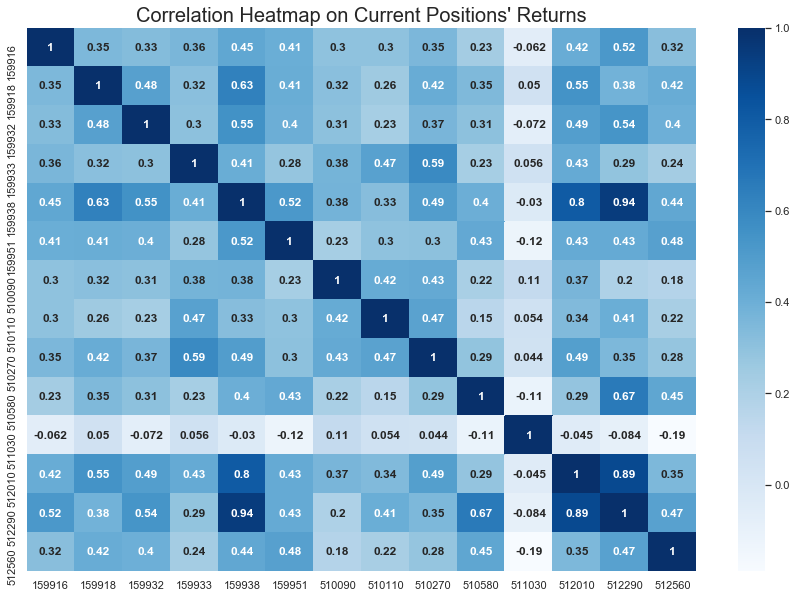

In [238]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
ax = sns.heatmap(cur_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Current Positions' Returns", fontsize = 20);

In [239]:
tgt_positions = list(signal_df[signal_df['TYPE_y']=="TARGET"]['code'])

In [240]:
# target_position-wise:
tgt_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, tgt_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
tgt_pos_merged_returns = merge_df_for_corr(tgt_pos_returns, "date")

Reading Assets:  159938
Reading Assets:  512010
Reading Assets:  512290
Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  512690
Reading Assets:  159919
Reading Assets:  159939
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets:  159949
Reading Assets:  512100
Reading Assets:  510510
Reading Assets:  510330
Reading Assets:  510300
Reading Assets:  512980
Reading Assets:  510310
Reading Assets:  159952
Reading Assets:  512500
Reading Assets:  512990


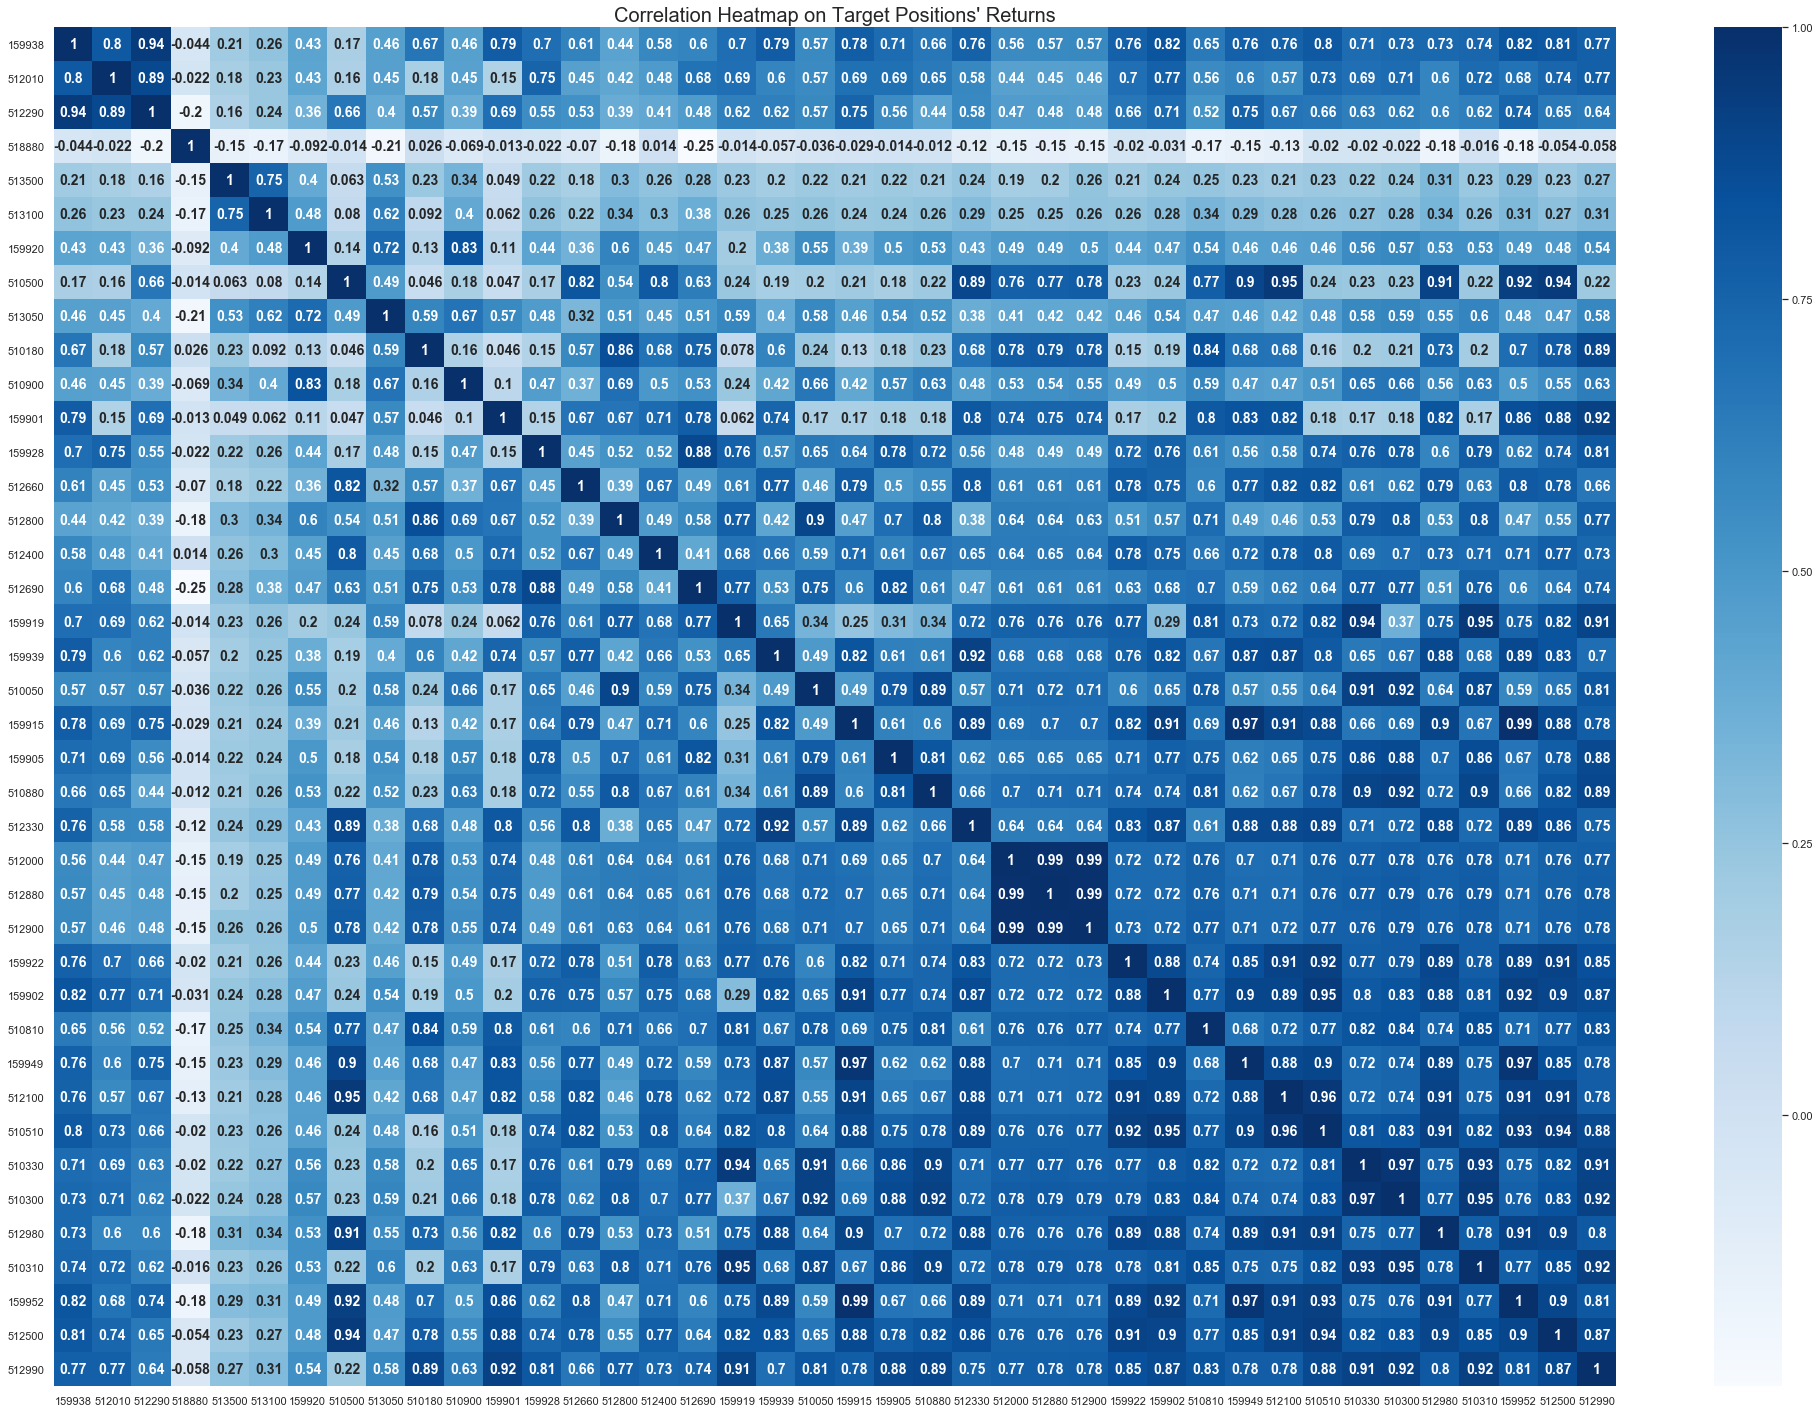

In [241]:
# corr heatmap of the target positions:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(tgt_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':14, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Target Positions' Returns", fontsize = 20);

In [270]:
signal_df

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT
0,2020-02-26,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
1,2020-02-26,159918,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
2,2020-02-26,159932,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
3,2020-02-26,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
4,2020-02-26,159938,空头状态,SHORT,CUR_POS,空头状态,SHORT,TARGET,0.0166511
5,2020-02-26,159951,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
6,2020-02-26,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
7,2020-02-26,510110,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
8,2020-02-26,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
9,2020-02-26,510580,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,


# Calculate position concentration risk - Position-wise correlations

In [352]:
# position-wise correlation:
# forward-fill all NaNs in the df of daily returns
cur_pos_merged_returns.fillna(method='ffill', inplace=True)
a = cur_pos_merged_returns.copy()

In [419]:
# Eliminate self-correlated data with correlations of 1. For now the rolling parameter is set to be 21 days
a_ = a.rolling(21).corr()[a.rolling(21).corr()<0.999999999]
a_.reset_index(inplace = True)
a_['date'] = a_['date'].astype(str)
del a_['level_1']
a__ = a_.groupby(['date']).apply(lambda x: x.mean().mean())
pos_21_rolling_corr = pd.DataFrame(a__, columns=['pos_corr']).tail(1)

## [Save] daily rolling position correlation data

In [439]:
# pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv")
# pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv", mode='a', header=False)

In [247]:
# assuming we already have SH index data updated and inplace
# Correlation to the SH index:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")

In [248]:
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index.dropna(inplace=True)
sh_index_index_date = sh_index.copy()
sh_index_index_date.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ts_code', 'pct_chg']
sh_index_index_date = sh_index_index_date[['date','pct_chg']]
sh_index_index_date.columns = ['date','sh_index']

In [250]:
cur_pos_merged_returns_with_sh = cur_pos_merged_returns.copy()
cur_pos_merged_returns_with_sh.reset_index(inplace = True)
cur_pos_merged_returns_with_sh['date'] = cur_pos_merged_returns_with_sh['date'].astype(str)
cur_pos_merged_returns_with_sh = cur_pos_merged_returns_with_sh.merge(sh_index_index_date, on = 'date')

In [253]:
corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    corr_with_sh_index = pct_series.corr(sh_index_pct_series)
    corrs_cur_pos_with_sh_index.append(corr_with_sh_index)

In [254]:
cur_pos_merged_returns_with_sh.index = pd.to_datetime(cur_pos_merged_returns_with_sh['date'])

In [255]:
cur_pos_merged_returns_with_sh.dropna(inplace = True)

In [256]:
# calculate rolling correlations
rolling_corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    rolling_corr_with_sh_index = pct_series.rolling(21).corr(sh_index_pct_series)
    rolling_corrs_cur_pos_with_sh_index.append(rolling_corr_with_sh_index)

In [257]:
rolling_corrs_cur_pos_sh_index_df = pd.concat(rolling_corrs_cur_pos_with_sh_index, axis=1)
rolling_corrs_cur_pos_sh_index_df.columns = cur_positions

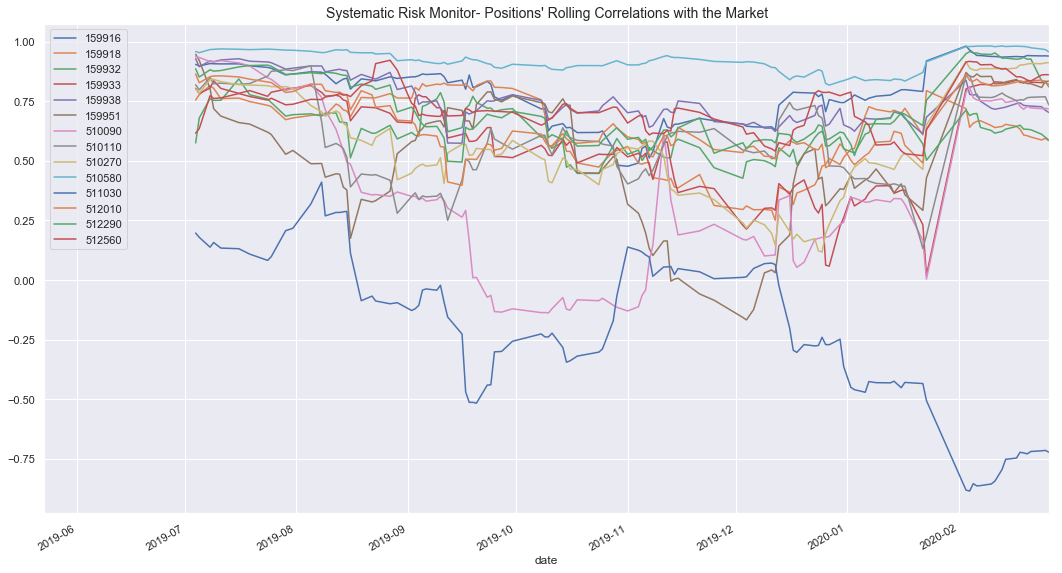

In [258]:
rolling_corrs_cur_pos_sh_index_df.plot(figsize = (18,10))
plt.title("Systematic Risk Monitor- Positions' Rolling Correlations with the Market", fontsize = 14);

In [274]:
rolling_corrs_cur_pos_sh_index_df

,159916,159918,159932,159933,159938,159951,510090,510110,510270,510580,511030,512010,512290,512560
date,,,,,,,,,,,,,,
2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-20,0.941836,0.605265,0.926383,0.833082,0.731017,0.824061,0.728739,0.764845,0.906568,0.978227,-0.729652,0.836720,0.632487,0.838725
2020-02-21,0.941161,0.599879,0.927164,0.829977,0.729560,0.823621,0.722473,0.766640,0.908203,0.974243,-0.719608,0.835249,0.630405,0.834933
2020-02-24,0.940204,0.587431,0.834879,0.828080,0.726981,0.807593,0.718897,0.768090,0.907438,0.969113,-0.716810,0.839102,0.611426,0.860305


# Performance Tracking

In [259]:
date = [
    "2020-01-02",
    "2020-01-03",
    "2020-01-06",
    "2020-01-07",
    "2020-01-08",
    "2020-01-09",
    "2020-01-10",
    "2020-01-13",
    "2020-01-14",
    "2020-01-15",
    "2020-01-16",
    "2020-01-17",
    "2020-01-20",
    "2020-01-21",
    "2020-01-22",
    "2020-01-23",
    "2020-02-03",
    "2020-02-04",
    "2020-02-05",
    "2020-02-06",
    "2020-02-07",
    "2020-02-10",
    "2020-02-11",
    "2020-02-12",
    "2020-02-13",
    "2020-02-14",
    "2020-02-17",
    "2020-02-18",
    "2020-02-19",
    "2020-02-20",
    "2020-02-21",
    "2020-02-24",
    "2020-02-25",
    "2020-02-26"
]
sbtv1 = [0+1,#1/2
        0+1,
        0+1,
        0+1,
        -0.005/100+1,
        -0.001/100+1,
        0.01/100+1,
        0.01/100+1,
        0.03/100+1,
        0.02/100+1,
        -0.03/100+1,
        0.06/100+1,
        0.07/100+1,
        0.13/100+1,
        0.0795/100+1,
        0.2/100+1,
        0.68136/100+1,
         710/200000+1,#2/4
         824.42/200000+1,#2/5
         654.42/200000+1,#2/6
         745.42/200000+1,#2/7
         833/200000+1,#2/8
         933/200000+1,#2/11
         911/200000+1,
         676.53/200000+1,
         882.52/200000+1,
         1813.76/200000+1,
         2210.96/200000+1,
         1947.66/200000+1,
         2553.70/200000+1,
         2881.31/200000+1, #2020-02-21
         3423.72/200000+1,
         3239.46/200000+1,
         2397.44/200000+1
        ]

In [260]:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index_2020 = sh_index[sh_index['trade_date']>='2020-01-02']
sh_index_2020['adjusted_pct_chg'] = sh_index_2020['pct_chg']
sh_index_2020['adjusted_pct_chg'].values[0] = 0
sh_index_2020['cum_sum_pct_chg'] = sh_index_2020['adjusted_pct_chg'].cumsum()+1

track_record = pd.DataFrame()
track_record['date'] = date
track_record['sbtv1'] = sbtv1
track_record['sh_mkt'] = sh_index_2020['cum_sum_pct_chg'].values
track_record.index = pd.to_datetime(track_record['date'])
del track_record['date']

track_record['returns0'] = track_record['sbtv1'].diff()
track_record['returns0'].values[0] = 0
track_record['returns1'] = track_record['sh_mkt'].diff()
track_record['returns1'].values[0] = 0

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [261]:
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)

def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_expected_annual_returns(pnl, periods=252):
    traded_days = len(pnl)
    last_pnl = pnl.values[-1]
    annual_returns = (1+last_pnl)**(periods/traded_days)-1
    return annual_returns

def create_total_returns(pnl):
    return pnl.values[-1]

In [262]:
# Calculate Alpha and Beta:

import statsmodels.api as sm
from statsmodels import regression

X = track_record['returns1'].values
Y = track_record['returns0'].values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print("alpha: ", str(alpha))
print("beta: ", str(beta))

alpha:  0.0003324935603264803
beta:  -0.025017976347264572


- 计算alpha，beta

https://blog.csdn.net/CoderPai/article/details/82868280 

In [263]:
sharpe_ratio0 = create_sharpe_ratio(track_record['returns0'], periods=252)
sharpe_ratio1 = create_sharpe_ratio(track_record['returns1'], periods=252)
drawdown0, max_drawdown0, max_dd_duration0 = create_drawdowns(track_record['sbtv1'])
drawdown1, max_drawdown1, max_dd_duration1 = create_drawdowns(track_record['sh_mkt'])
annual_returns0 = create_expected_annual_returns(track_record['sbtv1']-1)
annual_returns1 = create_expected_annual_returns(track_record['sh_mkt']-1)
total_returns0 = create_total_returns(track_record['sbtv1']-1)
total_returns1 = create_total_returns(track_record['sh_mkt']-1)
corr_returns0_1 = track_record['returns0'].corr(track_record['returns1'])
# jensen_alpha = total_returns0 - corr_returns0_1*total_returns1

*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 2. create_drawdowns*****
*****performance.py: 2. create_drawdowns*****


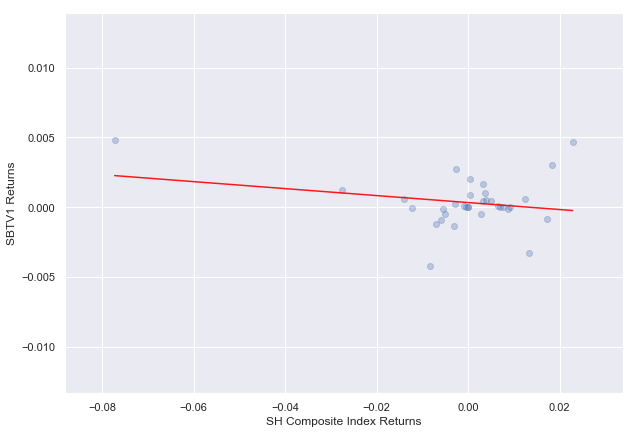

In [264]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2*beta+alpha

plt.figure(figsize=(10,7))
plt.scatter(X ,Y, alpha=0.3)
plt.xlabel("SH Composite Index Returns")
plt.ylabel("SBTV1 Returns")

plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()

In [265]:
last_day = sh_index['trade_date'].values[-1]

print("=========================SBTV1策略=======================")
print("\n")
print("SBTV1策略 - 开始时间：2020-01-02")
print("SBTV1策略 - 当前时间：{}".format(last_day))
print("SBTV1策略 - 实时 绝对收益：", round(total_returns0*100, 2), "%")
print("SBTV1策略 - 实时 夏普比率：", round(sharpe_ratio0, 2))
print("SBTV1策略 - 实时 期望年化收益率：", round(annual_returns0*100, 2),"%")
print("SBTV1策略 - 实时 最大回撤比率：", round(max_drawdown0*100,2), "%")
print("SBTV1策略 - 实时 最大回撤持续时间：", int(max_dd_duration0), "天")
print("SBTV1策略 - 实时 Beta：", round(beta, 4))
print("SBTV1策略 - 实时 超额收益Alpha：", round(total_returns0-total_returns1, 4))
print("SBTV1策略 - 实时 风险调整Alpha：", round(alpha, 6))
print("\n")
print("=========================上证指数=======================")
print("\n")
print("上证指数 - 开始时间：2020-01-02")
print("上证指数 - 当前时间：{}".format(last_day))
print("上证指数 - 实时 绝对收益：", round(total_returns1*100,2), "%")
print("上证指数 - 实时 夏普比率：", round(sharpe_ratio1, 2))
print("上证指数 - 实时 最大回撤比率：", round(max_drawdown1*100,2), "%")
print("上证指数 - 实时 最大回撤持续时间：", int(max_dd_duration1), "天")

=========================SBTV1策略=======================


SBTV1策略 - 开始时间：2020-01-02
SBTV1策略 - 当前时间：2020-02-26
SBTV1策略 - 实时 绝对收益： 1.2 %
SBTV1策略 - 实时 夏普比率： 3.23
SBTV1策略 - 实时 期望年化收益率： 9.23 %
SBTV1策略 - 实时 最大回撤比率： 0.51 %
SBTV1策略 - 实时 最大回撤持续时间： 9 天
SBTV1策略 - 实时 Beta： -0.025
SBTV1策略 - 实时 超额收益Alpha： 0.0393
SBTV1策略 - 实时 风险调整Alpha： 0.000332


=========================上证指数=======================


上证指数 - 开始时间：2020-01-02
上证指数 - 当前时间：2020-02-26
上证指数 - 实时 绝对收益： -2.73 %
上证指数 - 实时 夏普比率： -0.78
上证指数 - 实时 最大回撤比率： 12.24 %
上证指数 - 实时 最大回撤持续时间： 26 天


In [266]:
my_strat_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sbtv1'],
    name = 'SBTV1策略累计收益率'
)
 
    
mkt_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sh_mkt'],
    name = '上证指数累积收益率'
)
    
layout = dict(title = 'SBTV1策略累计收益率',
              xaxis = dict(title = '时间'), # 横轴坐标
              yaxis = dict(title = '收益率'), # 总轴坐标
              legend=dict(x=1.1,y=1) # 图例位置 
              )

data = [my_strat_plot, mkt_plot]

fig = dict(data=data, layout=layout)

py.iplot(fig)

# Check Details of Filtered ETFs

In [267]:
og_etf_file = pd.read_csv(etf_ticker_path)
corr_mean_df_assets['etf'] = corr_mean_df_assets['etf']+".OF"
og_etf_file.columns = ['etf', '证券简称', '投资类型(一级分类)', '投资类型(二级分类)', '基金规模\n[单位] 元',
       '机构投资者持有份额\n[报告期] 2019中报\n[单位] 份', '机构投资者持有比例\n[报告期] 2019中报\n[单位] %',
       '管理费率\n[单位] %', '托管费率\n[单位] %', '认购费率\n[收费类型] 前端']
corr_mean_df_assets_info = corr_mean_df_assets.merge(og_etf_file, on = 'etf')

In [268]:
corr_mean_df_assets_info.to_csv("filtered_50_etfs_by_vol_20200224.csv")

# Calculate Market Slippage and Impact

In [269]:
vol_filtered_df

,date,open,close,high,low,volume,code,252_vol_ewm,vol_ewm_rank
16310,2020-02-26,1.051,1.053,1.084,1.045,22548927.0,512880,8.453609e+06,1.0
18096,2020-02-26,1.190,1.199,1.204,1.188,19411923.0,510900,8.399864e+06,2.0
27664,2020-02-26,0.838,0.811,0.847,0.806,14475999.0,159949,6.838174e+06,3.0
4153,2020-02-26,2.868,2.894,2.919,2.861,7132264.0,510050,5.921174e+06,4.0
14075,2020-02-26,2.162,2.102,2.176,2.086,6436769.0,159915,5.021894e+06,5.0
26790,2020-02-26,1.470,1.476,1.482,1.466,9189500.0,159920,4.926911e+06,6.0
33931,2020-02-26,1.006,1.001,1.032,0.995,12248736.0,512000,3.819503e+06,7.0
6039,2020-02-26,4.064,4.070,4.118,4.048,6417933.0,510300,3.577870e+06,8.0
19699,2020-02-26,3.667,3.668,3.678,3.632,7777393.0,518880,3.547398e+06,9.0
1688,2020-02-26,6.298,6.217,6.356,6.201,2850427.0,510500,2.271613e+06,10.0
